c:\Users\123\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 109569, number of negative: 109568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 219137, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27393
           1       1.00      0.94      0.97     27392

    accuracy                           0.97     54785
   macro avg       0.97      0.97      0.97     54785
weighted avg       0.97      0.97      0.97     54785

ROC-AUC: 0.974405817070822
Average Precision (AUC-PR): 0.9839984701734358
Confusion M

c:\Users\123\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


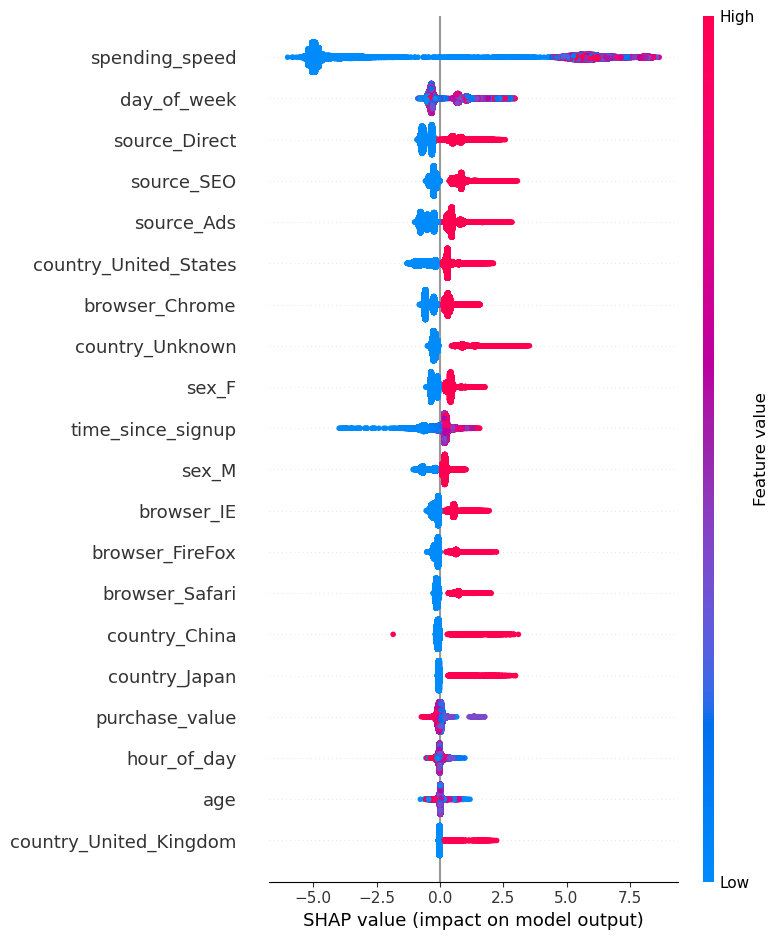

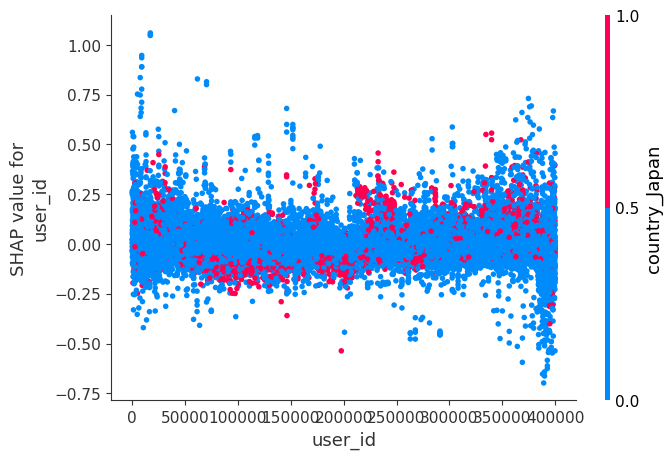

✅ Updated Model Saved to models\best_model_with_new_features.pkl


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
import shap
import os
import joblib

# ----------------------------
# Load Processed Fraud Data
# ----------------------------
df_fraud = pd.read_csv("../data/processed/enhanced_processed_fraud_data.csv")

# ----------------------------
# Feature Engineering: Add New Features
# ----------------------------
# Define thresholds for new features
time_threshold = 24 * 60 * 60  # 24 hours in seconds
spending_speed_threshold = df_fraud['spending_speed'].quantile(0.95)  # 95th percentile

# Create new binary flags
df_fraud['is_new_user'] = (df_fraud['time_since_signup'] < time_threshold).astype(int)
df_fraud['is_rapid_spender'] = (df_fraud['spending_speed'] > spending_speed_threshold).astype(int)

# ----------------------------
# Separate Features and Target
# ----------------------------
X = df_fraud.drop(columns=['class'])
y = df_fraud['class']

# Train-test split (stratified because of imbalanced classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# Sanitize Column Names for LightGBM
# ----------------------------
def sanitize_columns(df):
    df = df.copy()
    df.columns = [re.sub(r"[^0-9a-zA-Z_]", "_", c) for c in df.columns]
    return df

X_train = sanitize_columns(X_train)
X_test = sanitize_columns(X_test)

# ----------------------------
# Logistic Regression
# ----------------------------
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)

# ----------------------------
# LightGBM
# ----------------------------
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)
lgb_model.fit(X_train, y_train)

# ----------------------------
# Evaluation Function
# ----------------------------
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("Average Precision (AUC-PR):", average_precision_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Evaluate both models
evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
evaluate_model(lgb_model, X_test, y_test, "LightGBM")

# ----------------------------
# SHAP Explainability
# ----------------------------
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

# Dependence Plot Example for Top Feature
top_feature = X_test.columns[0]
shap.dependence_plot(top_feature, shap_values, X_test)

# ----------------------------
# Save the Updated Model
# ----------------------------
os.makedirs("models", exist_ok=True)
model_path = os.path.join("models", "best_model_with_new_features.pkl")
joblib.dump(lgb_model, model_path)

print(f"✅ Updated Model Saved to {model_path}")